## Question 3

### STEP 1 — Import Libraries + Set Device

Here I import all required libraries (PyTorch, torchvision, plotting tools) and selecting GPU if available.

In [ ]:
# Step 1: Import libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import random
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

# Selecting device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


### STEP 2 — Define the black_box (4 transformations)

Here I define the hidden transformation system.

Each image will be transformed using one of four rules:

0 → Invert

1 → Flip Vertical

2 → Flip Horizontal

3 → Scanlines

This is the oracle system that our MoE must learn.

In [ ]:
# Step 2: Define black_box transformation

def black_box(img, mode):
    """
    img: Tensor (1, 28, 28)
    mode: integer in {0,1,2,3}
    """

    if mode == 0:
        # Invert
        return 1 - img

    elif mode == 1:
        # Flip vertical (up-down)
        return torch.flip(img, dims=[1])

    elif mode == 2:
        # Flip horizontal (left-right)
        return torch.flip(img, dims=[2])

    elif mode == 3:
        # Scanlines (zero every alternate row)
        img_clone = img.clone()
        img_clone[:, ::2, :] = 0
        return img_clone


### STEP 3 — Create Custom Dataset (Input → black_box Target)

Here I load Fashion-MNIST.

For every image, I randomly choose a transformation mode (0–3) and generate the target using black_box().

I also flatten images to (784,) for MLP.

In [ ]:
# Step 3: Custom dataset for MoE

class MoEDataset(Dataset):
    def __init__(self, train=True):
        transform = transforms.ToTensor()

        self.dataset = torchvision.datasets.FashionMNIST(
            root="./data",
            train=train,
            download=True,
            transform=transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image (1,28,28)
        img, _ = self.dataset[idx]

        # Random hidden transformation rule
        mode = random.randint(0, 3)

        # Oracle target from black_box
        target = black_box(img, mode)

        # Flatten to 784 for MLP
        return img.view(-1), target.view(-1), mode


### STEP 4 — Create DataLoaders (Train + Test)

Here I create the training and testing datasets and load them in batches using DataLoader.

In [ ]:
# Step 4: Create train/test loaders

train_dataset = MoEDataset(train=True)
test_dataset  = MoEDataset(train=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


Train size: 60000
Test size: 10000


### STEP 5 — Implement the ExplicitMoE Model (Gate + Experts)


Here I build the required architecture from the handout

Gate (Router): takes input image → outputs probabilities over 4 experts

Experts: 4 separate MLPs, each predicts an output image

Forward: final output = weighted sum of expert outputs using gate weights

I also include self.tau for Gumbel-Softmax routing (to avoid mode collapse)

In [ ]:
# Step 5: Explicit Mixture of Experts model

class ExplicitMoE(nn.Module):
    def __init__(self, input_dim=784, hidden=256, num_experts=4):
        super().__init__()
        self.num_experts = num_experts

        # Temperature for gumbel-softmax (we will adjust during training)
        self.tau = 5.0

        # Gate network (router)
        self.gate = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_experts)
        )

        # 4 expert networks (small MLPs)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, input_dim)
            ) for _ in range(num_experts)
        ])

    def forward(self, x):
        # ----- Gate -----
        gate_logits = self.gate(x)

        # Gumbel-softmax encourages exploration (prevents expert collapse)
        gate_weights = F.gumbel_softmax(
            gate_logits,
            tau=self.tau,
            hard=False,
            dim=1
        )  # (batch, 4)

        # ----- Experts -----
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # (batch, 4, 784)

        # ----- Weighted sum -----
        output = (gate_weights.unsqueeze(-1) * expert_outputs).sum(dim=1)  # (batch, 784)

        return output, gate_weights


### STEP 6 — Initialize Model, Loss, Optimizer + Balancing Loss

Here I:

Create the MoE model and move it to device

Use MSELoss (image-to-image regression)

Use Adam optimizer

Add MoE balancing loss so the gate doesn’t collapse into one expert

In [ ]:
# Step 6: Initialize model + training tools

model = ExplicitMoE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


ExplicitMoE(
  (gate): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
  (experts): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=784, bias=True)
    )
  )
)


#### Now add balancing loss:

In [ ]:
# Load balancing loss (prevents one expert doing everything)

def moe_balance_loss(gate_weights, eps=1e-9):
    """
    gate_weights: (B, E)
    Encourages uniform expert usage using importance + load.
    """
    B, E = gate_weights.shape

    # Importance: total probability mass per expert
    importance = gate_weights.sum(dim=0)  # (E,)

    # Load: count top-1 expert selections
    top1 = gate_weights.argmax(dim=1)  # (B,)
    load = torch.bincount(top1, minlength=E).float().to(gate_weights.device)

    # Normalize
    importance = importance / (importance.sum() + eps)
    load = load / (load.sum() + eps)

    # Balance objective (scaled)
    return (importance * load).sum() * (E ** 2)


### STEP 7 — Training Loop (with tau schedule + balancing loss)

Here I train the MoE end-to-end.

Epoch 1–3: high tau=5.0 → exploration (gate stays spread)

Epoch 4+ : lower tau=1.0 → specialization (gate becomes confident)

Total loss = MSE + λ * balance_loss to prevent collapse

In [ ]:
# Step 7: Train the MoE

epochs = 10
lambda_lb = 10.0  # strong balancing weight to prevent collapse

for epoch in range(1, epochs + 1):

    # Temperature schedule
    if epoch <= 3:
        model.tau = 5.0
    else:
        model.tau = 1.0

    model.train()
    running_loss = 0.0

    for imgs, targets, _ in train_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs, gate_weights = model(imgs)

        mse = criterion(outputs, targets)
        lb = moe_balance_loss(gate_weights)

        loss = mse + lambda_lb * lb
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch:02d} | tau={model.tau} | Train Loss: {avg_loss:.4f}")


Epoch 01 | tau=5.0 | Train Loss: 40.2469
Epoch 02 | tau=5.0 | Train Loss: 40.2435
Epoch 03 | tau=5.0 | Train Loss: 40.2346
Epoch 04 | tau=1.0 | Train Loss: 40.5761
Epoch 05 | tau=1.0 | Train Loss: 40.5697
Epoch 06 | tau=1.0 | Train Loss: 40.5492
Epoch 07 | tau=1.0 | Train Loss: 40.5948
Epoch 08 | tau=1.0 | Train Loss: 40.6083
Epoch 09 | tau=1.0 | Train Loss: 40.5937
Epoch 10 | tau=1.0 | Train Loss: 40.5866


### STEP 8 — Expert Usage + Specialization Heatmap (Fresh)

Here I evaluate the trained model on the test set:

Compute expert usage distribution (top-1 routing counts)

Compute average gate confidence per transformation mode (specialization check)

In [ ]:
# Step 8: Collect gate weights + modes on test set

model.eval()
all_gates = []
all_modes = []

with torch.no_grad():
    for imgs, _, modes in test_loader:
        imgs = imgs.to(device)
        _, gw = model(imgs)

        all_gates.append(gw.cpu())
        all_modes.append(modes)

all_gates = torch.cat(all_gates)   # (N,4)
all_modes = torch.cat(all_modes)   # (N,)
print("Collected gates:", all_gates.shape)


Collected gates: torch.Size([10000, 4])


#### 8a) Expert usage distribution

In [ ]:
top_expert = all_gates.argmax(dim=1)
counts = torch.bincount(top_expert, minlength=4).float()
print("Expert usage distribution:", counts / counts.sum())


Expert usage distribution: tensor([0.2440, 0.2525, 0.2574, 0.2461])


#### 8b) Specialization heatmap (avg confidence per mode)

Average gate confidence per mode:
 tensor([[0.2453, 0.2542, 0.2545, 0.2460],
        [0.2450, 0.2503, 0.2521, 0.2526],
        [0.2511, 0.2508, 0.2545, 0.2436],
        [0.2442, 0.2614, 0.2569, 0.2374]])


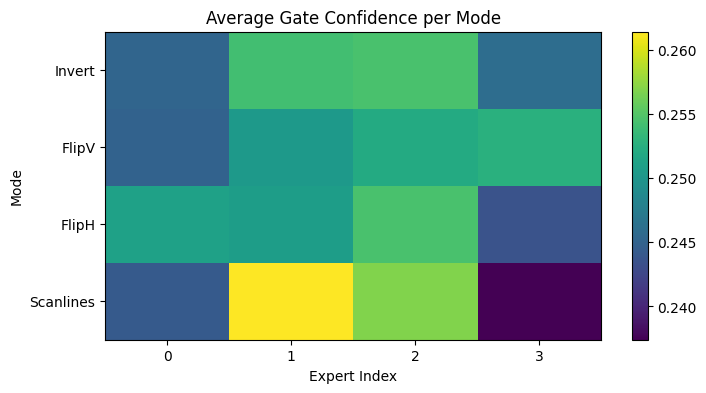

In [ ]:
mode_names = ["Invert", "FlipV", "FlipH", "Scanlines"]

avg_conf = []
for m in range(4):
    mask = (all_modes == m)
    avg_conf.append(all_gates[mask].mean(dim=0))

avg_conf = torch.stack(avg_conf)  # (4,4)
print("Average gate confidence per mode:\n", avg_conf)

plt.figure(figsize=(8,4))
plt.imshow(avg_conf.numpy(), aspect="auto")
plt.colorbar()
plt.xticks(range(4))
plt.yticks(range(4), mode_names)
plt.xlabel("Expert Index")
plt.ylabel("Mode")
plt.title("Average Gate Confidence per Mode")
plt.show()


### STEP 9 — Fix training: reduce balancing weight + add 2-phase training

We do two phases:

Phase A (learn task): small balancing so it can learn transformations
Phase B (encourage specialization): slightly increase balancing + lower tau

Also: print MSE separately so we know it’s learning.

#### Step 9A: Re-initialize model (fresh start)

In [ ]:
model = ExplicitMoE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


#### Step 9B: Train with better hyperparameters

Using these:

Epoch 1–4: tau=5.0, lambda_lb=0.1

Epoch 5–10: tau=1.0, lambda_lb=0.5

In [ ]:
epochs = 10

for epoch in range(1, epochs + 1):

    # Phase schedule
    if epoch <= 4:
        model.tau = 5.0
        lambda_lb = 0.1
    else:
        model.tau = 1.0
        lambda_lb = 0.5

    model.train()
    running_loss = 0.0
    running_mse  = 0.0
    running_lb   = 0.0

    for imgs, targets, _ in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs, gate_weights = model(imgs)

        mse = criterion(outputs, targets)
        lb  = moe_balance_loss(gate_weights)

        loss = mse + lambda_lb * lb
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mse  += mse.item()
        running_lb   += lb.item()

    print(
        f"Epoch {epoch:02d} | tau={model.tau} | "
        f"Loss={running_loss/len(train_loader):.4f} | "
        f"MSE={running_mse/len(train_loader):.4f} | "
        f"LB={running_lb/len(train_loader):.4f} | "
        f"lambda_lb={lambda_lb}"
    )


Epoch 01 | tau=5.0 | Loss=0.5511 | MSE=0.1501 | LB=4.0104 | lambda_lb=0.1
Epoch 02 | tau=5.0 | Loss=0.5458 | MSE=0.1449 | LB=4.0098 | lambda_lb=0.1
Epoch 03 | tau=5.0 | Loss=0.5455 | MSE=0.1445 | LB=4.0099 | lambda_lb=0.1
Epoch 04 | tau=5.0 | Loss=0.5448 | MSE=0.1439 | LB=4.0088 | lambda_lb=0.1
Epoch 05 | tau=1.0 | Loss=2.1666 | MSE=0.1452 | LB=4.0428 | lambda_lb=0.5
Epoch 06 | tau=1.0 | Loss=2.1641 | MSE=0.1438 | LB=4.0406 | lambda_lb=0.5
Epoch 07 | tau=1.0 | Loss=2.1665 | MSE=0.1456 | LB=4.0417 | lambda_lb=0.5
Epoch 08 | tau=1.0 | Loss=2.1665 | MSE=0.1451 | LB=4.0428 | lambda_lb=0.5
Epoch 09 | tau=1.0 | Loss=2.1662 | MSE=0.1441 | LB=4.0442 | lambda_lb=0.5
Epoch 10 | tau=1.0 | Loss=2.1671 | MSE=0.1453 | LB=4.0436 | lambda_lb=0.5


### STEP 10 — Generate required report figures

#### Step 10A: 3×5 grid (Input / Target / Prediction)

Matches the deliverable: top=input, middle=oracle target, bottom=model prediction.

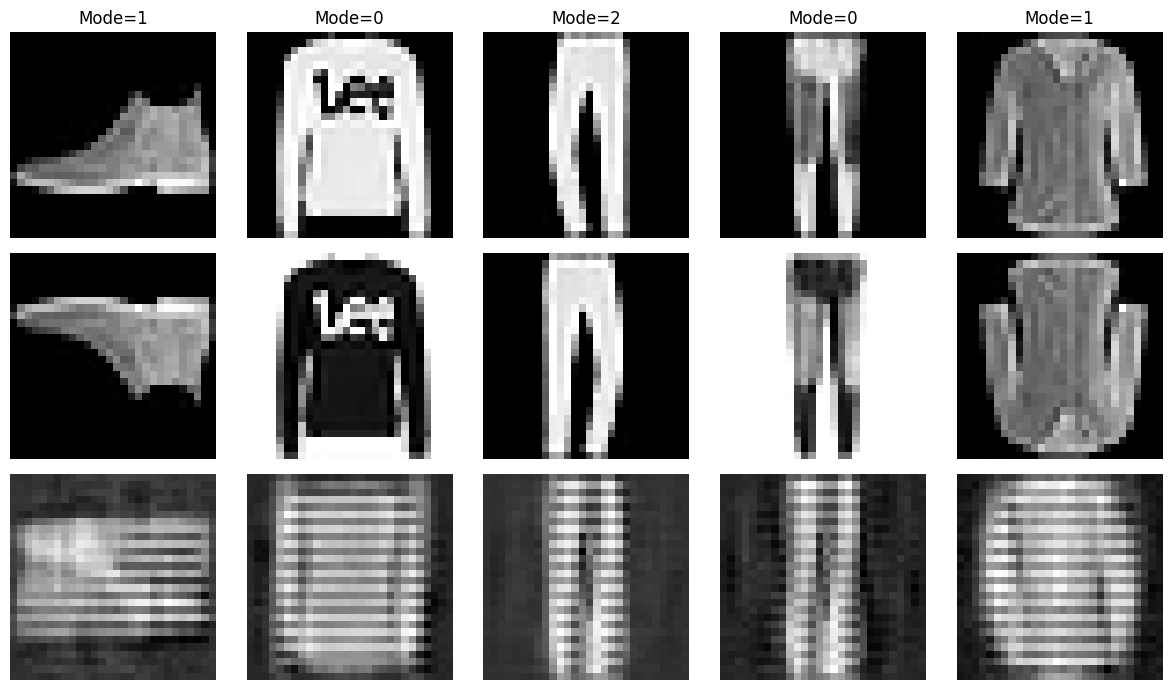

In [ ]:
# Step 10A: 3x5 visualization grid

def visualize_3x5(model, dataset):
    model.eval()
    fig, axes = plt.subplots(3, 5, figsize=(12, 7))

    for i in range(5):
        x, y, mode = dataset[i]
        x = x.to(device)

        with torch.no_grad():
            pred, _ = model(x.unsqueeze(0))

        x_img = x.cpu().view(28, 28)
        y_img = y.view(28, 28)
        p_img = pred.cpu().view(28, 28)

        axes[0, i].imshow(x_img, cmap="gray")
        axes[1, i].imshow(y_img, cmap="gray")
        axes[2, i].imshow(p_img, cmap="gray")

        axes[0, i].set_title(f"Mode={mode}")
        axes[0, i].axis("off")
        axes[1, i].axis("off")
        axes[2, i].axis("off")

    axes[0, 0].set_ylabel("Input")
    axes[1, 0].set_ylabel("Target")
    axes[2, 0].set_ylabel("Prediction")

    plt.tight_layout()
    plt.show()

visualize_3x5(model, test_dataset)

#### Step 10B: Expert usage + specialization heatmap (fresh)

This is the interpretability analysis deliverable.

Expert usage distribution: tensor([0.2500, 0.2476, 0.2477, 0.2547])
Average gate confidence per mode:
 tensor([[0.2615, 0.2440, 0.2423, 0.2521],
        [0.2476, 0.2539, 0.2549, 0.2437],
        [0.2422, 0.2454, 0.2507, 0.2617],
        [0.2461, 0.2524, 0.2507, 0.2508]])


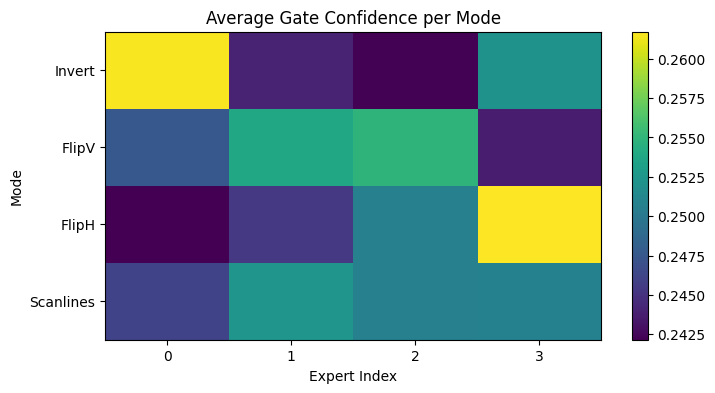

In [ ]:
# Step 10B: Expert usage + specialization

model.eval()
all_gates = []
all_modes = []

with torch.no_grad():
    for imgs, _, modes in test_loader:
        imgs = imgs.to(device)
        _, gw = model(imgs)
        all_gates.append(gw.cpu())
        all_modes.append(modes)

all_gates = torch.cat(all_gates)
all_modes = torch.cat(all_modes)

# Expert usage distribution (top-1)
top_expert = all_gates.argmax(dim=1)
counts = torch.bincount(top_expert, minlength=4).float()
print("Expert usage distribution:", counts / counts.sum())

# Average gate confidence per mode
mode_names = ["Invert", "FlipV", "FlipH", "Scanlines"]
avg_conf = []
for m in range(4):
    mask = (all_modes == m)
    avg_conf.append(all_gates[mask].mean(dim=0))

avg_conf = torch.stack(avg_conf)
print("Average gate confidence per mode:\n", avg_conf)

plt.figure(figsize=(8,4))
plt.imshow(avg_conf.numpy(), aspect="auto")
plt.colorbar()
plt.xticks(range(4))
plt.yticks(range(4), mode_names)
plt.xlabel("Expert Index")
plt.ylabel("Mode")
plt.title("Average Gate Confidence per Mode")
plt.show()
